In [1]:
# import statements

import xarray as xr
import xesmf as xe
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import metpy
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# function because some of the simulations have a messed-up calendar
def fix_xtime(ds_in: xr.Dataset) -> xr.Dataset:
    ds_in.XTIME.attrs["units"] = "minutes since 2021-09-01 23:00:00"
    ds_in.XTIME.attrs["description"] = "minutes since 2021-09-01 23:00:00"
    return(ds_in)

# function to read in data
def load(path: str) -> xr.Dataset:
    return(xr.decode_cf(
        xr.open_mfdataset(path,preprocess=fix_xtime,
                          decode_times=False,combine="nested",concat_dim='Time')
                          )
    )

In [3]:
runs_list = []
# iterate through ensemble members
for i in range(2,18):
    path = "/mnt/drive2/wof-runs/23Z/wrfwof*.{:02d}".format(i)
    runs_list.append(load(path))

# create new "ens" dimension
runs = xr.concat(runs_list,"ens")

In [14]:
# separate a few variables
rainnc = runs.metpy.parse_cf("RAINNC").load()
heli02 = runs.metpy.parse_cf("UP_HELI_MAX02").load()
lat = runs.XLAT.isel(Time=0)
lon = runs.XLONG.isel(Time=0)

In [15]:
# get central latitude and longitude for projections
central_latitude = float(lat.mean())
central_longitude = float(lon.mean())

/tmp/ipykernel_972696/1998094113.py:17: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(wspace=0.04,hspace=0.04)


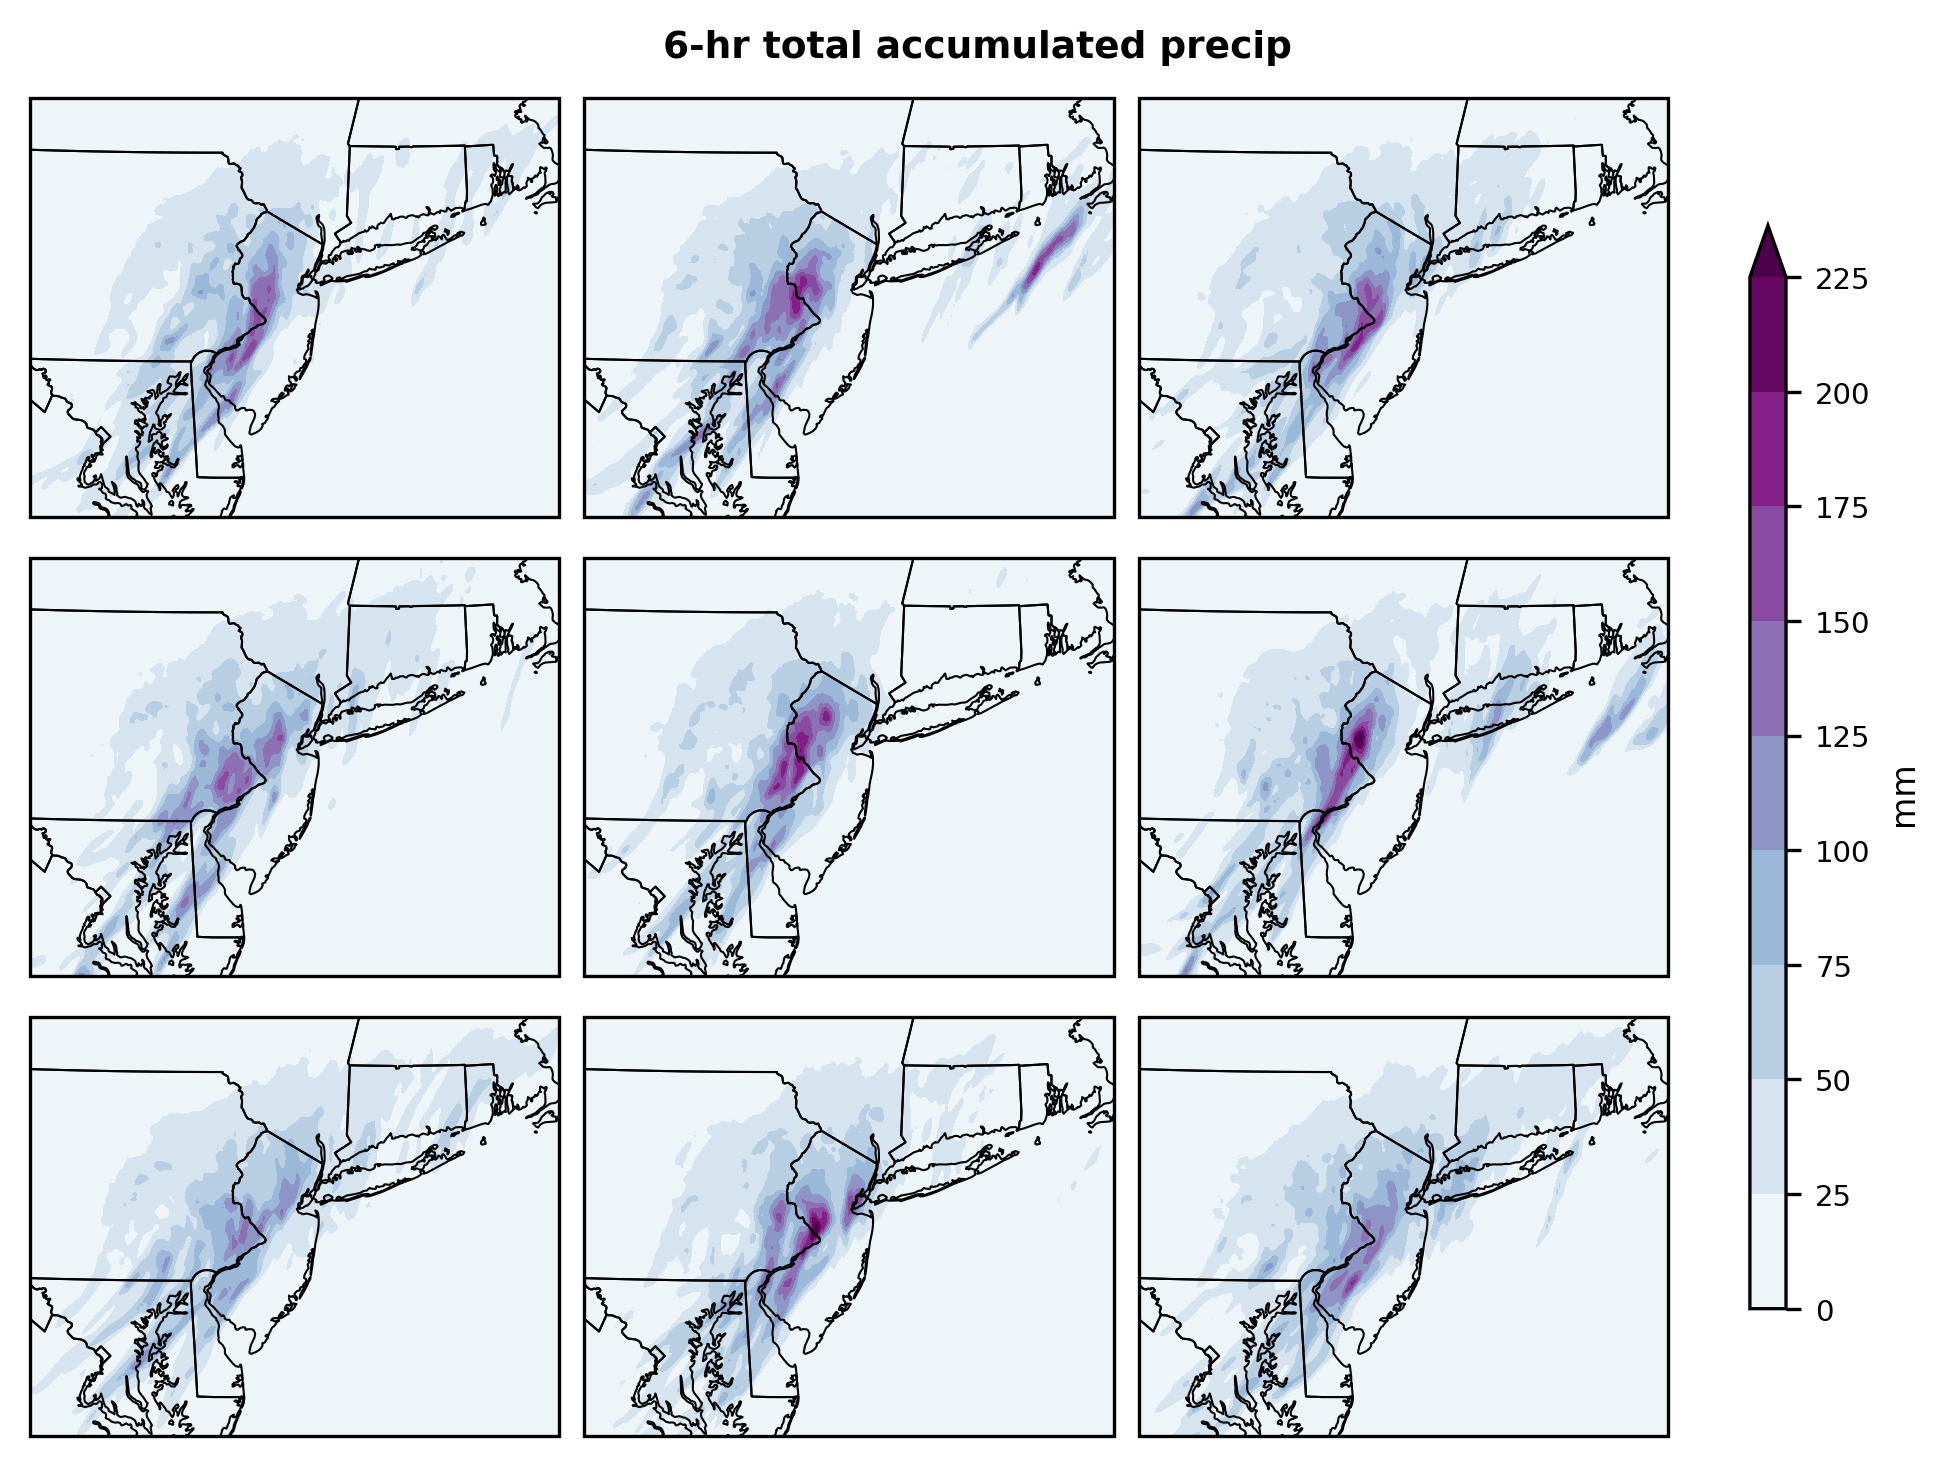

In [16]:
# define a few variables
linewidth=0.5
region = [-78,-70.7,38,42.5]
proj = ccrs.LambertConformal(central_longitude=central_longitude,
                             central_latitude=central_latitude)

fig, axes = plt.subplots(3, 3, subplot_kw=dict(projection=proj),
                         dpi=300,layout="constrained")
for i,ax in enumerate(axes.flatten()):
    p = ax.contourf(lon,lat,rainnc.isel(Time=72,ens=i),
                    transform=ccrs.PlateCarree(),
                    cmap="BuPu",levels=np.arange(0,250,25),
                    extend="max")
    p.axes.set_extent(region,crs=ccrs.PlateCarree())
    p.axes.add_feature(cfeature.STATES,linewidth=linewidth)
    # p.axes.add_feature(cfeature.GSHHSFeature(scale="i"),linewidth=linewidth)
plt.subplots_adjust(wspace=0.04,hspace=0.04)
plt.suptitle("6-hr total accumulated precip",fontsize=9,fontweight='bold')
cbar = fig.colorbar(p,ax=axes,shrink=0.8,aspect=30)
cbar.ax.tick_params(labelsize=7)
cbar.set_label("mm",fontsize=8)
plt.show()

In [17]:
max_locs = heli02.argmax(dim=['south_north','west_east'])
lats = runs.XLAT.sel(south_north=max_locs['south_north'],
                     west_east=max_locs['west_east'])
lons = runs.XLONG.sel(south_north=max_locs['south_north'],
                     west_east=max_locs['west_east'])

/tmp/ipykernel_972696/2013372022.py:17: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(wspace=0.04,hspace=0.04)


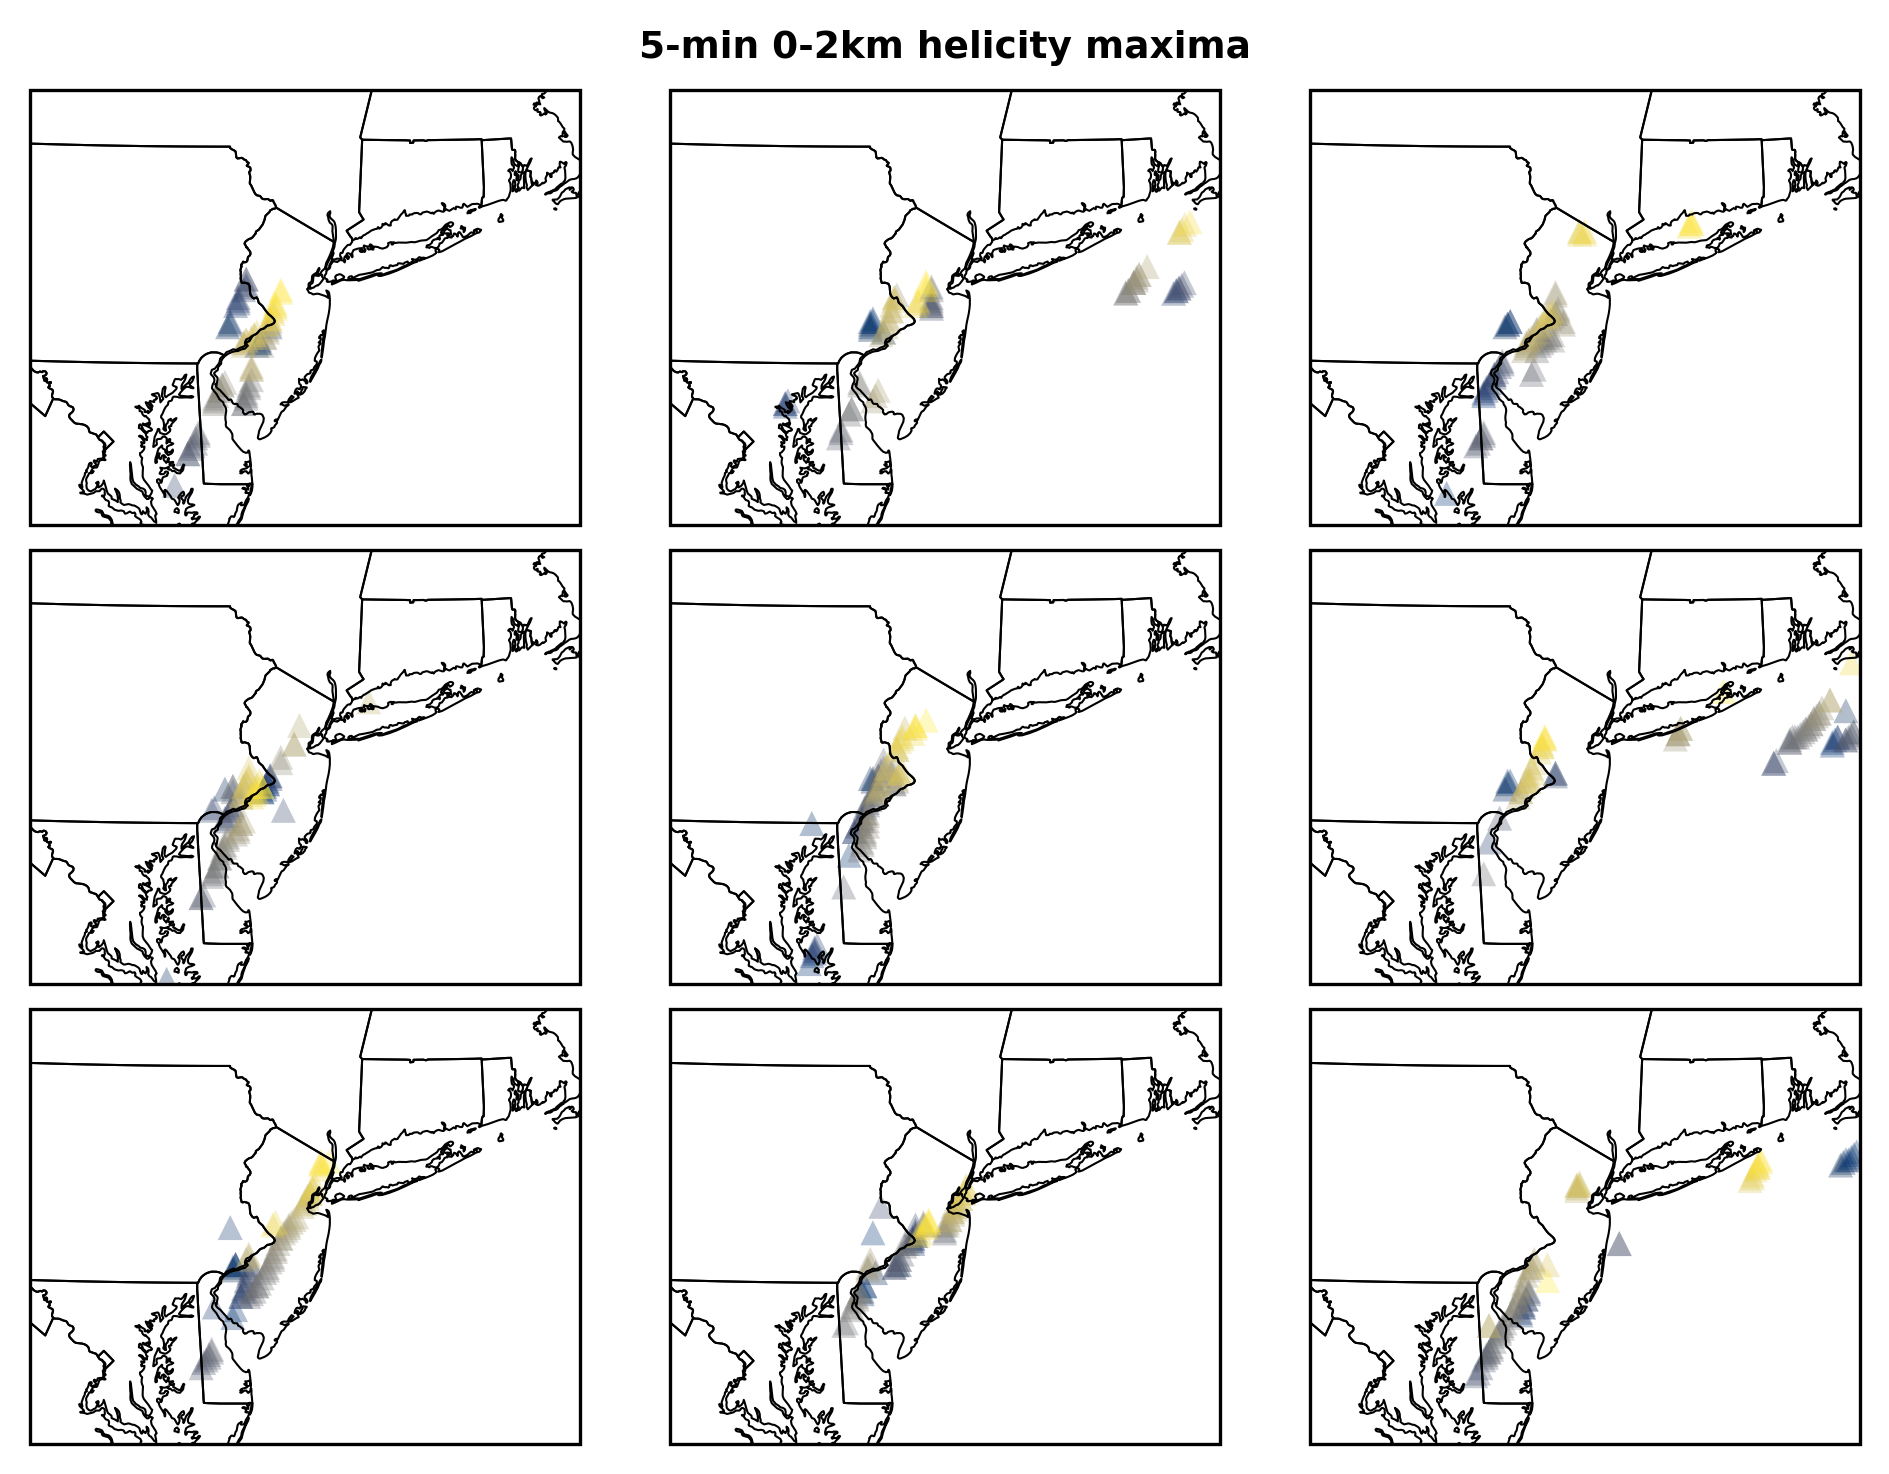

In [18]:
# define a few variables
linewidth=0.5
region = [-78,-70.7,38,42.5]
proj = ccrs.LambertConformal(central_longitude=central_longitude,
                             central_latitude=central_latitude)


fig, axes = plt.subplots(3, 3, subplot_kw=dict(projection=proj),
                         dpi=300,layout="constrained")
for i,ax in enumerate(axes.flatten()):
    s = ax.scatter(lons.isel(ens=i),lats.isel(ens=i),
                     transform=ccrs.PlateCarree(),
                     alpha=0.3,c=runs.XTIME,cmap='cividis',
                     marker='^',edgecolors='none')
    s.axes.add_feature(cfeature.STATES,linewidth=linewidth)
    s.axes.set_extent(region,crs=ccrs.PlateCarree())
plt.subplots_adjust(wspace=0.04,hspace=0.04)
plt.suptitle("5-min 0-2km helicity maxima",fontsize=9,fontweight='bold')
plt.show()
